In this notebook we'll be building our first LSTM model with the meteorological and site readings from the S.H Bell monitoring site. We'll first need to join all of the data and do some basic data cleaning and preparation.

In [100]:
import numpy as np
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

### Data Preparation

In [101]:
samples = pd.read_excel('data/sample_readings/shb_summary_of_all_continuous_data_november_2019_for_website_public_0.xlsx')
sample_copy = samples.copy()

In [102]:
samples.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24120 entries, 0 to 24119
Data columns (total 29 columns):
Transaction Type                     24120 non-null object
Action Code                          24120 non-null object
State Code                           24120 non-null int64
County Code                          24120 non-null int64
Site ID                              24120 non-null int64
Parameter                            24120 non-null int64
POC                                  24120 non-null int64
Sample Duration                      24120 non-null int64
Unit                                 24120 non-null int64
Method                               24120 non-null int64
Date                                 24120 non-null int64
Start Time                           24120 non-null object
Sample Value                         23902 non-null float64
Null Data Code                       299 non-null object
Sampling Frequency                   0 non-null float64
Monitor Protocol (M

We'll drop all of the columns that are completely empty and then look at the ones with a few non-null values to see if they're relevant.

In [103]:
samples.dropna(axis=1, how='all', inplace=True)

In [104]:
samples.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24120 entries, 0 to 24119
Data columns (total 15 columns):
Transaction Type    24120 non-null object
Action Code         24120 non-null object
State Code          24120 non-null int64
County Code         24120 non-null int64
Site ID             24120 non-null int64
Parameter           24120 non-null int64
POC                 24120 non-null int64
Sample Duration     24120 non-null int64
Unit                24120 non-null int64
Method              24120 non-null int64
Date                24120 non-null int64
Start Time          24120 non-null object
Sample Value        23902 non-null float64
Null Data Code      299 non-null object
Qualifier 1         50 non-null float64
dtypes: float64(2), int64(9), object(4)
memory usage: 2.8+ MB


In [105]:
samples['Qualifier 1'].value_counts()

9.0    50
Name: Qualifier 1, dtype: int64

In [106]:
samples['Null Data Code'].value_counts()

BA    188
BC     83
AN     18
AV      6
AZ      2
AM      2
Name: Null Data Code, dtype: int64

Descriptions of the qualifiers and null data codes can be found here: https://aqs.epa.gov/aqsweb/documents/codetables/qualifiers.html. According to this table, the values in the 'Qualifier 1' column were detected as negative. Since it doesn't make sense to have a negative reading of a PM concentration, they were instead reported as being 0. The readings in the 'Null Data Code' column are as follows:

- AM: Miscellaneous Void
- AN: Machine Malfunction
- AV: Power Failure
- AZ: Q C Audit
- BA: Maintenance/Routine Repairs
- BC: Multi-point Calibration

There doesn't seem to be any way to really deal with the null values, To make sure that we still have consistently hourly data, we'll do some interpolation. First, let's make sure that all of the values with a null data code are actually NaNs. If they aren't, we'll set them to NaN and then resample. The same will be done for for the 'Qualifier 1' column.

In [107]:
samples.loc[samples['Null Data Code'].notnull(), 'Sample Value'] = np.nan
samples.loc[samples['Qualifier 1'].notnull(), 'Sample Value'] = np.nan

In [108]:
samples[['Sample Value', 'Null Data Code', 'Qualifier 1']].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24120 entries, 0 to 24119
Data columns (total 3 columns):
Sample Value      23771 non-null float64
Null Data Code    299 non-null object
Qualifier 1       50 non-null float64
dtypes: float64(2), object(1)
memory usage: 565.4+ KB


In [109]:
# Checking to see if we have the correct number of null values
23771 + 50 + 299 == 24120

True

We'll now set the index to the time of measurement and drop the irrelevant columns. It turns out that the first 2928 values in the 'Start Time' column have dates and time, while the rest only have times. In order to address this, we'll extract the times, then convert them to strings and combine them with the 'Date' column. This new column, which we will just call 'datetime', will be set as the index for the samples DataFrame. We'll then drop the columns that we don't need before interpolating the missing sample values.

In [110]:
samples['Start Time'].apply(lambda x: type(x)).value_counts()

<class 'datetime.time'>        21192
<class 'datetime.datetime'>     2928
Name: Start Time, dtype: int64

In [111]:
samples.loc[:2928, 'Start Time'] = samples['Start Time'][:2928].dt.time

In [112]:
samples.loc[:, 'Start Time'] = samples['Start Time'].astype(str)
samples.loc[:, 'Date'] = samples['Date'].astype(str)

In [113]:
samples['datetime'] = pd.to_datetime(samples['Date'] + ' ' + samples['Start Time'],
                                     format='%Y%m%d %H', errors='coerce')

In [114]:
samples.drop(columns=['Transaction Type', 'Action Code', 'State Code', 'County Code',
                      'Site ID', 'Parameter', 'POC', 'Sample Duration', 'Unit',
                      'Method', 'Date', 'Start Time', 'Null Data Code', 'Qualifier 1'],
             inplace=True)
samples.set_index('datetime', inplace=True)

Now that we've taken care of the annoying datetime issue, we can move on to interpolating the missing values. We'll take a simple approach and just do this with cubic splines. It also turns out that we have a missing day around the beginning of June 2017. So, we'll have to reindex as well before inerpolating.

In [115]:
samples = samples.sort_index()

In [116]:
samples.index.value_counts().head()

2017-06-06 23:00:00    2
2018-08-01 12:00:00    1
2019-02-09 09:00:00    1
2017-09-25 11:00:00    1
2018-04-21 23:00:00    1
Name: datetime, dtype: int64

We also apparently have a duplicate date that we will have to deal with. Let's investigate this in more detail

In [117]:
samples['2017-06-06 23:00:00':].head()

,Sample Value
datetime,
2017-06-06 23:00:00,11.0
2017-06-06 23:00:00,10.0
2017-06-07 00:00:00,17.0
2017-06-07 01:00:00,12.0
2017-06-07 02:00:00,7.0


We'll just remove the second one since the values are so close.

In [118]:
samples = samples.loc[~samples.index.duplicated(keep='first')]

Finally, we remove the single null value

In [119]:
samples = samples.loc[~samples.index.isna()]

Now, after all of this cleaning we can finally interpolate our missing values with the linear spline. We'll be rounding to the nearest whole number here because the none of the given readings have decimal points. We'll first plot the values before assigning them to make sure that nothing looks weird.

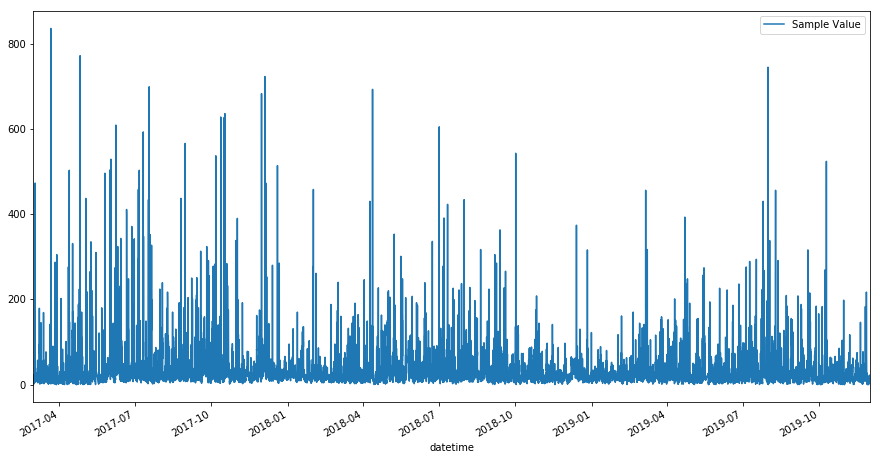

In [120]:
samples.interpolate(method='time').round(0).plot(figsize=(15,8))

Looks good!

In [121]:
samples = samples.interpolate(method='time').round(0)

### Modelling

The LSTM model working by learning a function that will map a sequence of previous observations to future observation. In order to facilitate this process, we'll define a helper function which will take a sequence of observations and split it into samples that the LSTM model will learn from

In [122]:
# split a univariate sequence into samples
def split_sequence(sequence, n_steps):
    X, y = list(), list()
    for i in range(len(sequence)):
        # find the end of this pattern
        end_ix = i + n_steps
        # check if we are beyond the sequence
        if end_ix > len(sequence)-1:
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

In [123]:
# Splitting the time series into sequences
# Using 96 hours of prior observations as the training set for a single step ahead
n_steps = 96
X, y = split_sequence(samples['2019':]['Sample Value'], n_steps)

#### Feature Scaling

We'll use a min-max scaler to scale the data, as the neural network will not be able to handle large differences in the concentration readings.

In [125]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
X = np.array([scaler.fit_transform(X[i,:].reshape(-1,1)) for i in range(X.shape[0])])

### Building the Model with Keras

In [127]:
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense

# Reshape X so that it represents a single feature
n_features = 1
X = X.reshape((X.shape[0], X.shape[1], n_features))
# Define the model
model = Sequential()
model.add(LSTM(25, activation='relu', return_sequences=True, input_shape=(n_steps, n_features)))
model.add(LSTM(10, activation='relu'))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')
# Fit the model
model.fit(X, y, epochs=10, verbose=1)

Epoch 1/10
7920/7920 [==============================] - 14s 2ms/step - loss: 2235.3588
Epoch 2/10
7920/7920 [==============================] - 14s 2ms/step - loss: 1568.2368
Epoch 3/10
7920/7920 [==============================] - 16s 2ms/step - loss: 1553.5442
Epoch 4/10
7920/7920 [==============================] - 16s 2ms/step - loss: 1538.8730
Epoch 5/10
7920/7920 [==============================] - 15s 2ms/step - loss: 1524.1988
Epoch 6/10
7920/7920 [==============================] - 15s 2ms/step - loss: 1509.5900
Epoch 7/10
7920/7920 [==============================] - 15s 2ms/step - loss: 1495.0579
Epoch 8/10
7920/7920 [==============================] - 14s 2ms/step - loss: 1480.5830
Epoch 9/10
7920/7920 [==============================] - 15s 2ms/step - loss: 1466.1528
Epoch 10/10
7920/7920 [==============================] - 15s 2ms/step - loss: 1451.7507


In [128]:
X_input = X[0]
X_input = X_input.reshape((1, n_steps, n_features))
y_hat = model.predict(X_input, verbose=0)

In [137]:
print(y[0], y_hat[0,0], sep=', ')

26.0, 4.790697


Clearly, the univariate model is not complex enough to correctly predict the PM10 readings from the S.H Bell site. In the next iteration of work, we need to think about including all of the available weather data from this site.